# EDA & Pre-processing (cont. from downsampled data)
#### This Exploratory Data Analysis to understand the data, as well as the preliminary data cleaning

## 0. Setup Environment & Config

In [1]:
# Set root directory (of this project) to import custom packages
import sys
ROOT_DIR = "../"
sys.path.append(ROOT_DIR)

In [2]:
# Import Public Packages
import gc
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import wfdb
from collections import defaultdict
from itertools import product
from peakutils import indexes
from scipy import signal
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from wfdb import processing
from tqdm import tqdm

In [3]:
# Import own packages / variables
from utils.common import print_blue, print_green, print_red
from utils.constants import RAW_DATA_DIR, PROCESSED_DATA_DIR

In [4]:
# Notebook configurations
pd.options.display.float_format = "{:,.4g}".format

## 1. Read Data

### 1.7 Heart Rate & Respiratory Signal Mapping

In [5]:
def plot_all_subsamples(data_dict, rr_peak_data_dict, config_summary, start_index, number_of_seconds, 
                        data_type="ECG", freq_after_scaled=False, plot_rr_peak=True, title=None, ylabel="mV", figsize=(23, 9)):
    fig, ax = plt.subplots(2, 5, figsize=figsize)
    axes = ax.ravel()
    if title is None:
        title = f"A {int(number_of_seconds)}-second subsample of {data_type} signals"
    plt.suptitle(title)
    if data_type == "ECG":
        color1, color2 = "maroon", "blue"
    else:
        color1, color2 = "blue", "maroon"
    for i in range(1, 11):
        if freq_after_scaled:
            interval = number_of_seconds * freq_after_scaled
        else:
            interval = number_of_seconds * config_summary.loc[i][f"{data_type.lower()}_fs"]
        end_index = start_index + interval
        axes[i-1].plot(data_dict[i][start_index: end_index], color=color1, label=f"{data_type} signal")
        axes[i-1].set_ylabel(ylabel)
        if plot_rr_peak:
            axes[i-1].plot(rr_peak_data_dict[i][start_index: end_index], color=color2, label=f"{data_type} peak", markersize=10, marker='x')
        axes[i-1].set_title(f"Infant {i}")
    plt.show()

In [6]:
def plot_heart_rates(heart_rate_dict, config_summary, start_index, number_of_seconds=60, 
                     data_type="ECG", freq_after_scaled=False, plot_rr_peak=True, title=None, ylabel="mV", figsize=(23, 9)):
    fig, ax = plt.subplots(2, 5, figsize=figsize)
    axes = ax.ravel()
    if title is None:
        title = f"A {int(number_of_seconds)}-second subsample of Heart Rate (bpm) from ECG signals"
    plt.suptitle(title)
    color1, color2 = "maroon", "blue"
    for i in range(1, 11):
        if freq_after_scaled:
            interval = number_of_seconds * freq_after_scaled
        else:
            interval = number_of_seconds * ecg_config_summary.loc[i][f"{data_type.lower()}_fs"]
        end_index = start_index + interval
        axes[i-1].plot(heart_rate_dict[i][start_index: end_index], color=color1, label=f"{data_type} signal")
        axes[i-1].set_title(f"Infant {i}")
    plt.show()

In [7]:
def plot_heart_rate_resp_window(heart_rate_data, resp_data, infant_no=4, index=100000, number_of_seconds=10, 
                                row=1, col=1, figsize=(10, 6), adjustment=0, resp_adjustment=0):
    fig, ax = plt.subplots(row, col, figsize=figsize)
    interval_size = number_of_seconds * 25
    ax.plot(resp_data[infant_no][index - resp_adjustment:index + interval_size - resp_adjustment], label="resp", color="blue", alpha=0.8)
    ax.legend(loc=2)
    ax2 = ax.twinx()
    ax2.plot(heart_rate_data[infant_no][index:index + interval_size], label="heart rate", color="red", alpha=1)
    ax2.legend(loc=1)
    plt.title(f"Infant{infant_no}, start_index: {index}, interval_size: {number_of_seconds:.0f} seconds")
    plt.show()

In [8]:
def check_both_series_length(heart_rate, resp_rate):
    for i in range(1, 11):
        print_blue(f"Infant {i} - Heart Rate length: {heart_rate[i].shape[0]}, RESP length: {resp_rate[i].shape[0]}")
        diff_in_len = heart_rate[i].shape[0] - resp_rate[i].shape[0]
        print_green(f"Diff in length: {diff_in_len} data points / {diff_in_len / 25} seconds off", end="\n\n")

In [9]:
%%time
heart_rate_dict = joblib.load("../processed_data/downsampled_heart_rates.pkl")
resp_data_dict = joblib.load("../processed_data/downsampled_resp_rates.pkl")

CPU times: user 22.8 ms, sys: 109 ms, total: 131 ms
Wall time: 135 ms


In [10]:
ecg_config_summary = pd.read_parquet("../processed_data/ecg_config_summary.parquet")
resp_config_summary = pd.read_parquet("../processed_data/resp_config_summary.parquet")

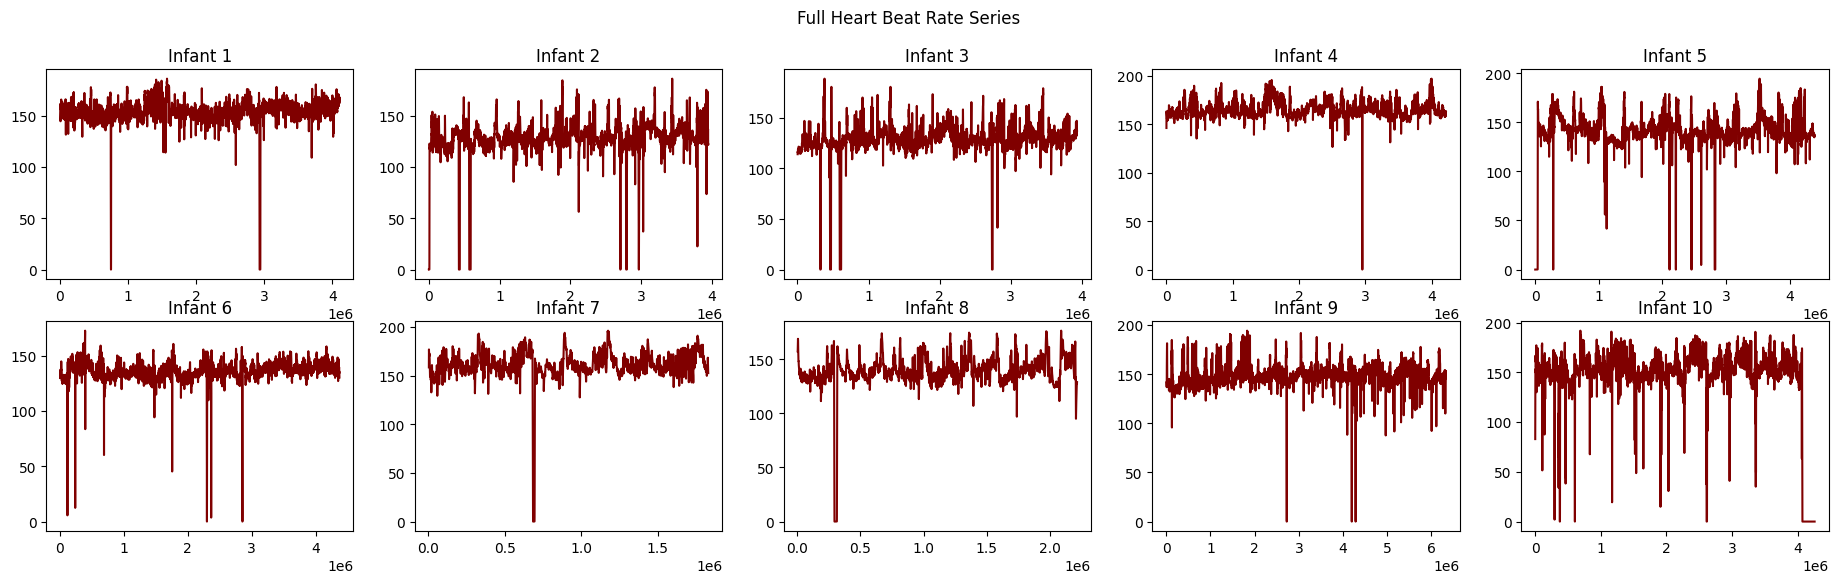

In [11]:
plot_heart_rates(heart_rate_dict, ecg_config_summary, start_index=0, title="Full Heart Beat Rate Series",
                 number_of_seconds=int(3 * 24 * 3600), figsize=(23, 6))

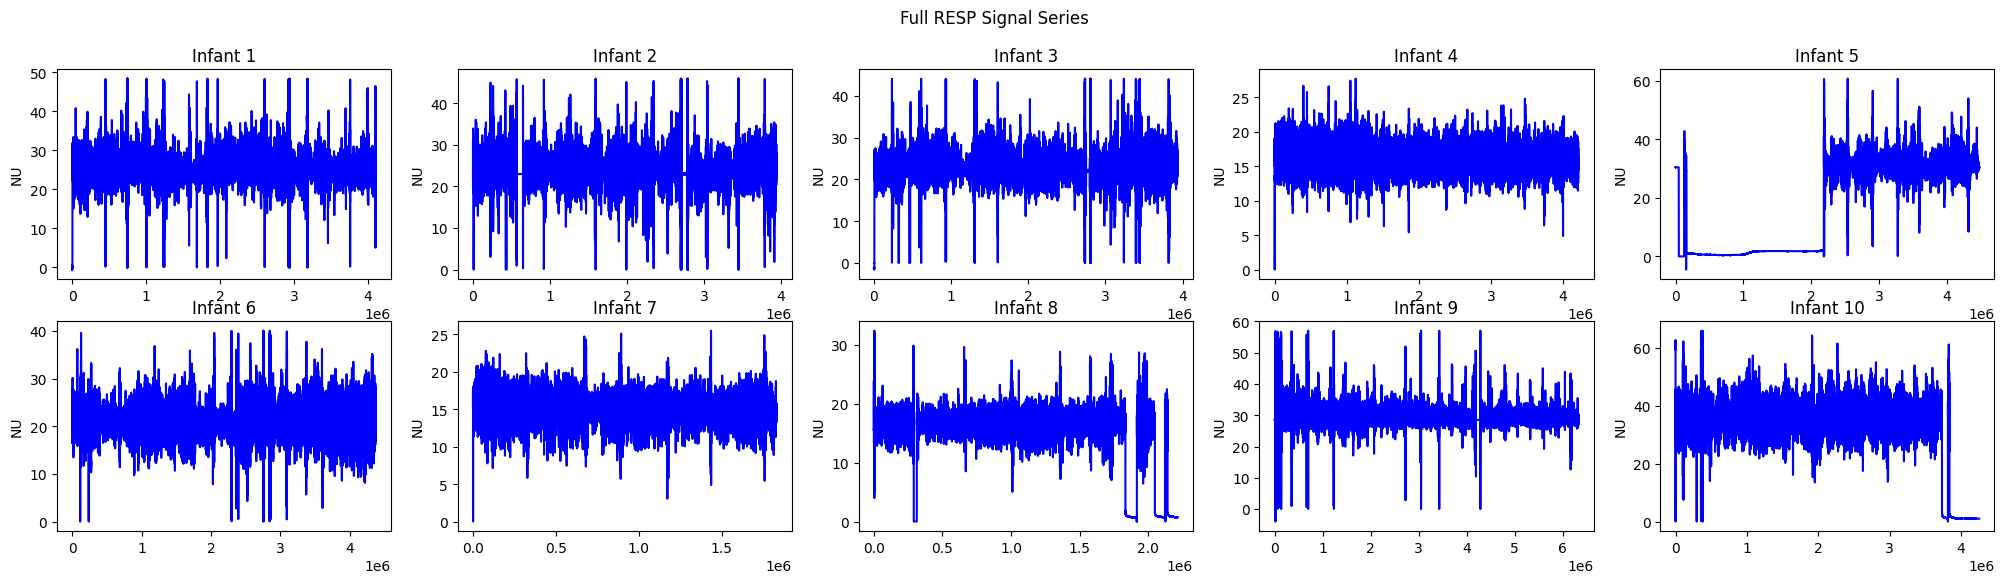

CPU times: user 2.31 s, sys: 598 ms, total: 2.91 s
Wall time: 2.57 s


In [12]:
%%time
plot_all_subsamples(resp_data_dict, None, resp_config_summary, data_type='RESP', title="Full RESP Signal Series", ylabel="NU",
                    start_index=0, number_of_seconds=int(3 * 24 * 3600), plot_rr_peak=False, figsize=(25, 6))

In [13]:
check_both_series_length(heart_rate_dict, resp_data_dict)

Infant 1 - Heart Rate length: 4105220, RESP length: 4106100
Diff in length: -880 data points / -35.2 seconds off

Infant 2 - Heart Rate length: 3945800, RESP length: 3945717
Diff in length: 83 data points / 3.32 seconds off

Infant 3 - Heart Rate length: 3934231, RESP length: 3934148
Diff in length: 83 data points / 3.32 seconds off

Infant 4 - Heart Rate length: 4210400, RESP length: 4210400
Diff in length: 0 data points / 0.0 seconds off

Infant 5 - Heart Rate length: 4387873, RESP length: 4477799
Diff in length: -89926 data points / -3597.04 seconds off

Infant 6 - Heart Rate length: 4374610, RESP length: 4374529
Diff in length: 81 data points / 3.24 seconds off

Infant 7 - Heart Rate length: 1830225, RESP length: 1830144
Diff in length: 81 data points / 3.24 seconds off

Infant 8 - Heart Rate length: 2214400, RESP length: 2214307
Diff in length: 93 data points / 3.72 seconds off

Infant 9 - Heart Rate length: 6328455, RESP length: 6328392
Diff in length: 63 data points / 2.52 secon

**Observations:**
- After downsampling, the length of the x axis is of the same scale between heart beat rate series and RESP signal series for each infant.

**Next Steps:**
- First trim the tail of each of the infant data so that both heart rate and RESP rate has the same length.
- Then, proceed to trim the first half of infant #5 data, and also the tail of Infant #8 and #10 due to missing / error in RESP measurement.
- Finally, map them point to point

In [14]:
# This part is manual selection
resp_data_dict[1] = resp_data_dict[1][:-880]
heart_rate_dict[2] = heart_rate_dict[2][:-83]
heart_rate_dict[3] = heart_rate_dict[3][:-83]
resp_data_dict[5] = resp_data_dict[5][89926:]
heart_rate_dict[6] = heart_rate_dict[6][:-81]
heart_rate_dict[7] = heart_rate_dict[7][:-81]
heart_rate_dict[8] = heart_rate_dict[8][:-93]
heart_rate_dict[9] = heart_rate_dict[9][:-63]
heart_rate_dict[10] = heart_rate_dict[10][:-86]

In [15]:
check_both_series_length(heart_rate_dict, resp_data_dict)

Infant 1 - Heart Rate length: 4105220, RESP length: 4105220
Diff in length: 0 data points / 0.0 seconds off

Infant 2 - Heart Rate length: 3945717, RESP length: 3945717
Diff in length: 0 data points / 0.0 seconds off

Infant 3 - Heart Rate length: 3934148, RESP length: 3934148
Diff in length: 0 data points / 0.0 seconds off

Infant 4 - Heart Rate length: 4210400, RESP length: 4210400
Diff in length: 0 data points / 0.0 seconds off

Infant 5 - Heart Rate length: 4387873, RESP length: 4387873
Diff in length: 0 data points / 0.0 seconds off

Infant 6 - Heart Rate length: 4374529, RESP length: 4374529
Diff in length: 0 data points / 0.0 seconds off

Infant 7 - Heart Rate length: 1830144, RESP length: 1830144
Diff in length: 0 data points / 0.0 seconds off

Infant 8 - Heart Rate length: 2214307, RESP length: 2214307
Diff in length: 0 data points / 0.0 seconds off

Infant 9 - Heart Rate length: 6328392, RESP length: 6328392
Diff in length: 0 data points / 0.0 seconds off

Infant 10 - Heart R

In [16]:
# This part is also manual selection
heart_rate_dict[5] = heart_rate_dict[5][2_600_000:]
resp_data_dict[5] = resp_data_dict[5][2_600_000:]

heart_rate_dict[8] = heart_rate_dict[8][:1_840_000]
resp_data_dict[8] = resp_data_dict[8][:1_840_000]

heart_rate_dict[10] = heart_rate_dict[10][:3_730_000]
resp_data_dict[10] = resp_data_dict[10][:3_730_000]

In [17]:
check_both_series_length(heart_rate_dict, resp_data_dict)

Infant 1 - Heart Rate length: 4105220, RESP length: 4105220
Diff in length: 0 data points / 0.0 seconds off

Infant 2 - Heart Rate length: 3945717, RESP length: 3945717
Diff in length: 0 data points / 0.0 seconds off

Infant 3 - Heart Rate length: 3934148, RESP length: 3934148
Diff in length: 0 data points / 0.0 seconds off

Infant 4 - Heart Rate length: 4210400, RESP length: 4210400
Diff in length: 0 data points / 0.0 seconds off

Infant 5 - Heart Rate length: 1787873, RESP length: 1787873
Diff in length: 0 data points / 0.0 seconds off

Infant 6 - Heart Rate length: 4374529, RESP length: 4374529
Diff in length: 0 data points / 0.0 seconds off

Infant 7 - Heart Rate length: 1830144, RESP length: 1830144
Diff in length: 0 data points / 0.0 seconds off

Infant 8 - Heart Rate length: 1840000, RESP length: 1840000
Diff in length: 0 data points / 0.0 seconds off

Infant 9 - Heart Rate length: 6328392, RESP length: 6328392
Diff in length: 0 data points / 0.0 seconds off

Infant 10 - Heart R

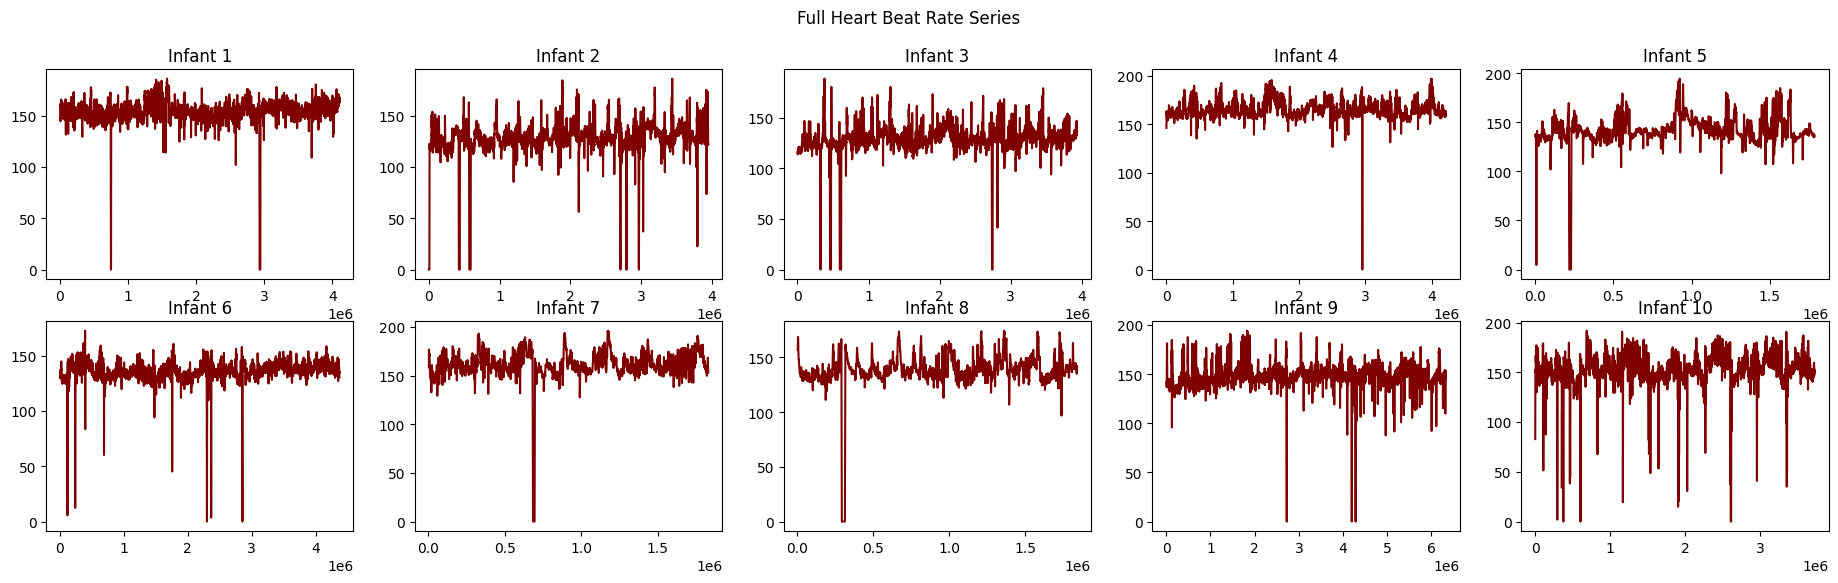

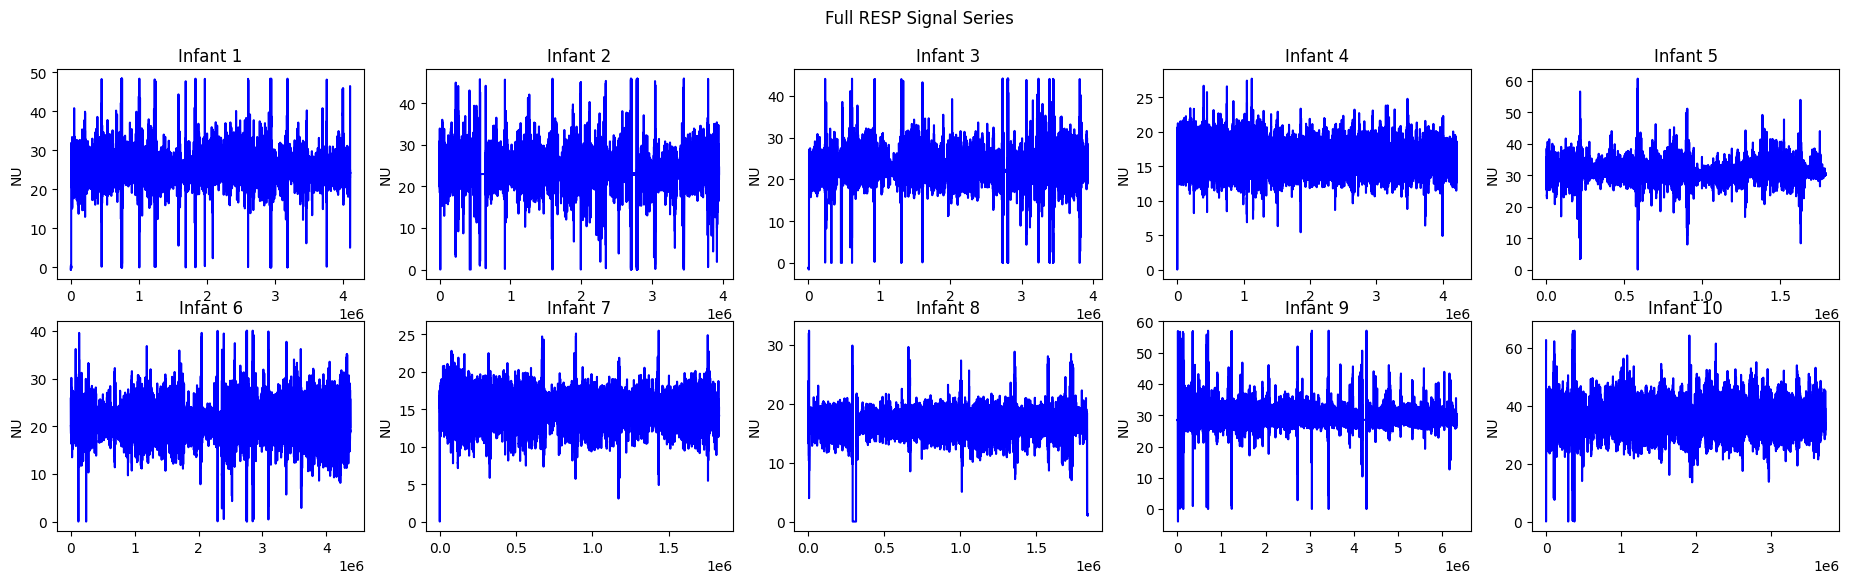

In [18]:
plot_heart_rates(heart_rate_dict, ecg_config_summary, start_index=0, title="Full Heart Beat Rate Series",
                 number_of_seconds=int(3 * 24 * 3600), figsize=(23, 6))
plot_all_subsamples(resp_data_dict, None, resp_config_summary, data_type='RESP', title="Full RESP Signal Series", ylabel="NU",
                    start_index=0, number_of_seconds=int(3 * 24 * 3600), plot_rr_peak=False, figsize=(23, 6))

**Observations:**
- Looks Good

### 1.8 Respiratory Signal Processing

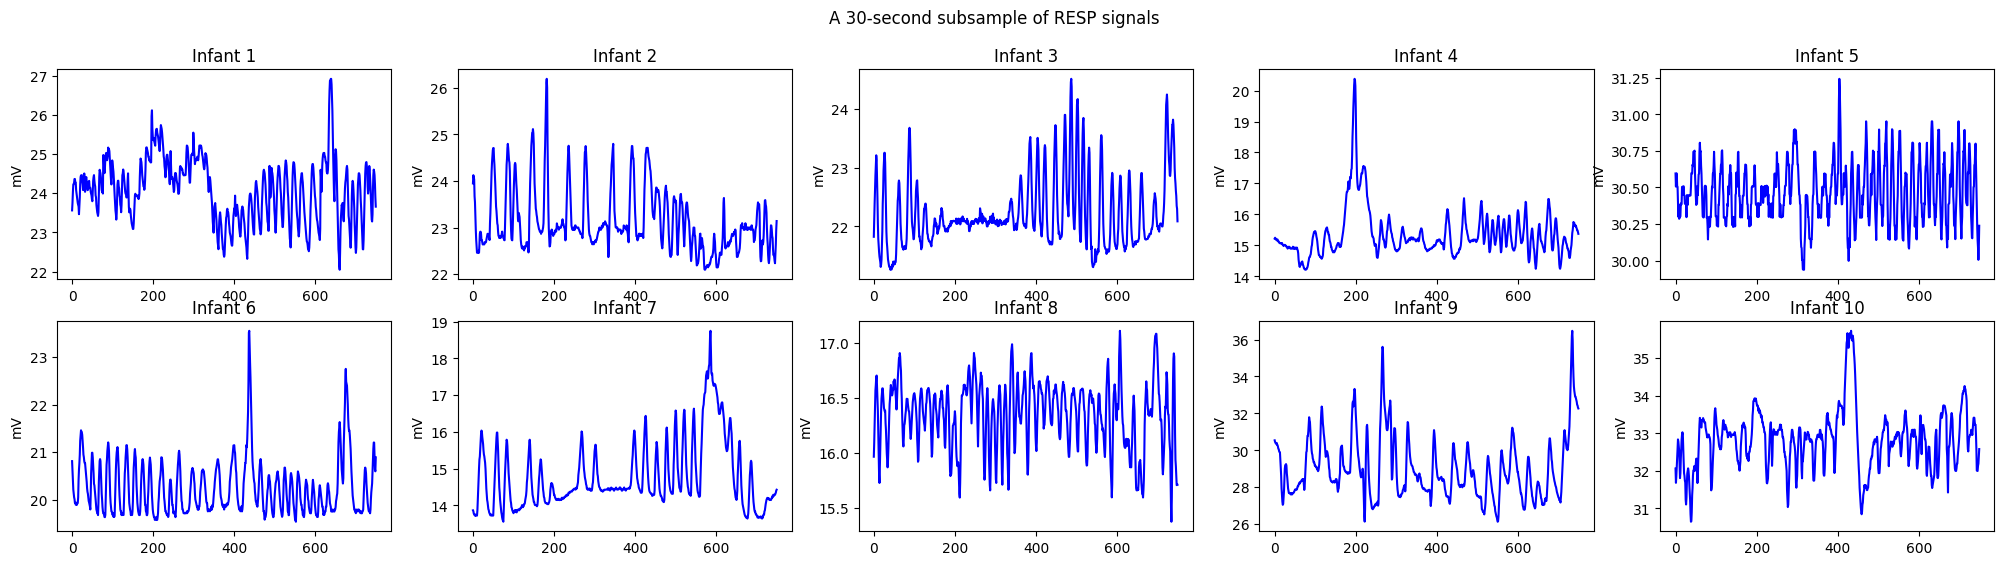

CPU times: user 977 ms, sys: 296 ms, total: 1.27 s
Wall time: 742 ms


In [19]:
%%time
plot_all_subsamples(resp_data_dict, None, resp_config_summary, plot_rr_peak=False, data_type="RESP", start_index=500_000, number_of_seconds=30, figsize=(25, 6))
# plot_all_subsamples(resp_data_dict, None, resp_config_summary, plot_rr_peak=False, data_type="RESP", start_index=700_000, number_of_seconds=3, figsize=(25, 6))

In [20]:
for i in range(1, 11):
    resp_data_dict[i] = pd.Series(resp_data_dict[i]).rolling(25).mean().rolling(25).mean().values

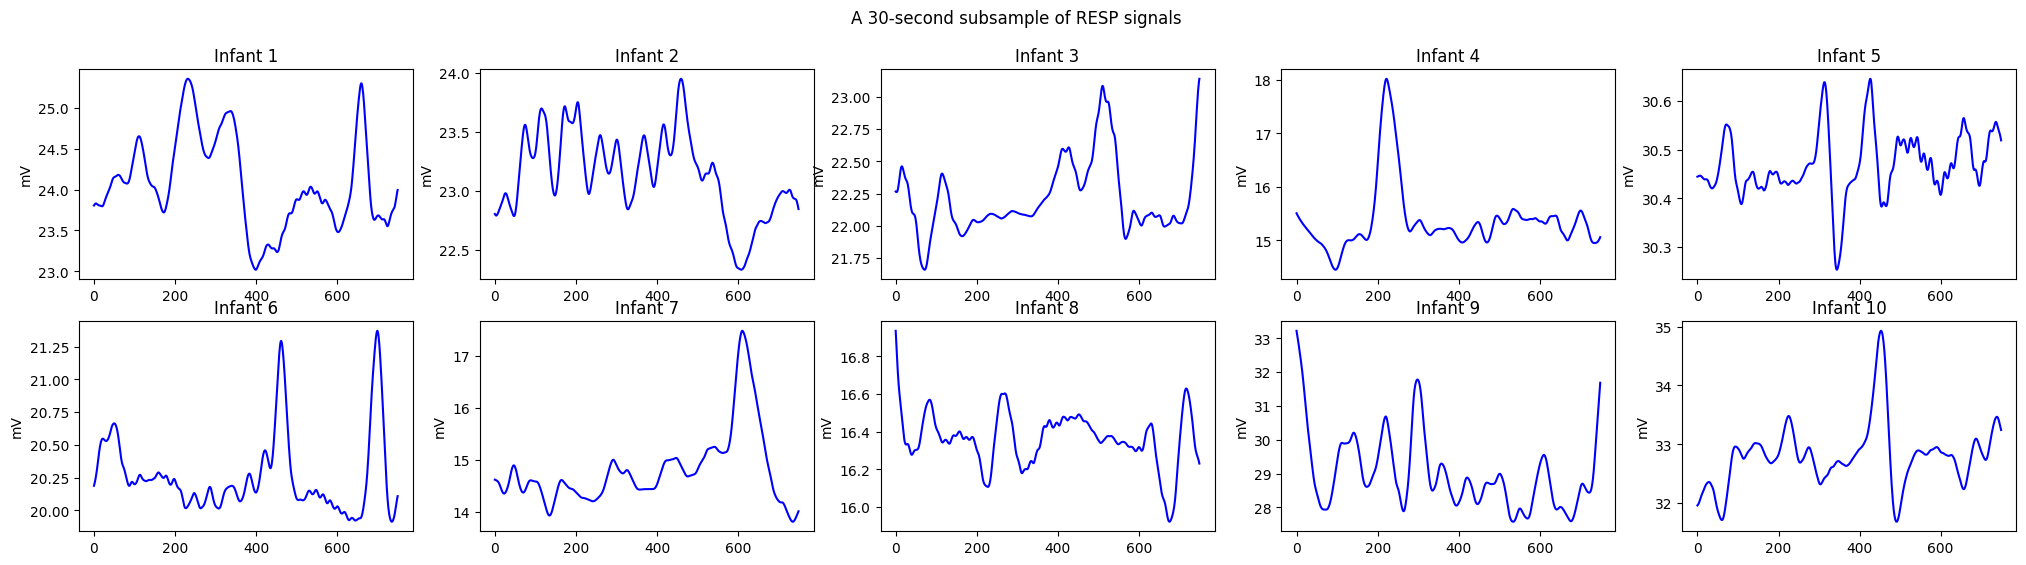

CPU times: user 899 ms, sys: 12.8 ms, total: 912 ms
Wall time: 374 ms


In [21]:
%%time
plot_all_subsamples(resp_data_dict, None, resp_config_summary, plot_rr_peak=False, data_type="RESP", start_index=500_000, number_of_seconds=30, figsize=(25, 6))

In [22]:
%%time
joblib.dump(heart_rate_dict, "../processed_data/master_heart_rates.pkl")
joblib.dump(resp_data_dict, "../processed_data/master_resp_rates.pkl")

CPU times: user 22 ms, sys: 146 ms, total: 168 ms
Wall time: 174 ms


['../processed_data/master_resp_rates.pkl']